# Loading the data

In [2]:
import pandas as pd
import numpy as np

import torch
from sklearn.model_selection import train_test_split
from torch import nn
from sklearn.calibration import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import ConfusionMatrixDisplay

# set seed 
seed = 0
torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_encoded.csv', sep='|')

In [4]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Columns: 735 entries, num__budget to category
dtypes: float64(734), object(1)
memory usage: 49.3+ MB
None
   num__budget  num__revenue  num__popularity  num__runtime  num__vote_count  \
0     4.757463      1.005269         0.425819      0.448734         1.716450   
1     2.894642      1.159981         0.366180     -0.230573         1.636140   
2     3.826052      2.100421         0.503760      0.739865         1.420090   
3     2.628524      0.670763         0.183190     -0.230573         1.375134   
4     1.510832      0.743000         0.159881     -0.085007         0.961366   

   num__release_year  num__release_month  cat__original_language_ar  \
0           0.483259           -0.241059                        0.0   
1           0.605583           -0.533445                        0.0   
2           0.789068           -0.241059                        0.0   
3           0.727906            0.343713               

In [5]:
desired_order = ['bad', 'mediocre', 'good', 'great']
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(desired_order)
df['category'] = label_encoder.transform(df['category'])

# NN

In [6]:
X = df.drop('category', axis=1)
Y = df['category']

In [7]:
print(X.shape)

(8784, 734)


In [8]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [9]:
# Create a custom Dataset class
class MovieDataset(Dataset):
    def __init__(self, features, labels):
        # Convert features to a NumPy array if it's a DataFrame
        if isinstance(features, pd.DataFrame):
            features = features.to_numpy()  # Convert DataFrame to NumPy array
        
        self.X = torch.tensor(features, dtype=torch.float32)  # Convert features to tensor
        self.y = torch.tensor(labels, dtype=torch.long)       # Convert labels to tensor

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

if isinstance(Y_train, pd.Series):
    Y_train = Y_train.to_numpy()

if isinstance(Y_test, pd.Series):
    Y_test = Y_test.to_numpy()

# Create Dataset objects
train_dataset = MovieDataset(X_train, Y_train)
test_dataset = MovieDataset(X_test, Y_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
# Define the neural network
class MovieClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MovieClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)    # First hidden layer
        self.fc2 = nn.Linear(128, 64)            # Third hidden layer
        self.fc3 = nn.Linear(64, 16)             # Fourth hidden layer
        self.output = nn.Linear(16, num_classes) # Output layer

        # Activation function
        self.relu = nn.ReLU()
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.output(x)
        return x
    

In [11]:
input_size = X_train.shape[1]  # Number of input features
num_classes = len(np.unique(Y_train))  # Number of classes in the target
model = MovieClassifier(input_size, num_classes)

# Set the device
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5, amsgrad=True, eps=1e-8) 

# Training loop
num_epochs = 50  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/50], Loss: 1.1798
Epoch [2/50], Loss: 0.8287
Epoch [3/50], Loss: 0.6857
Epoch [4/50], Loss: 0.6040
Epoch [5/50], Loss: 0.9147
Epoch [6/50], Loss: 0.7324
Epoch [7/50], Loss: 0.6112
Epoch [8/50], Loss: 0.5826
Epoch [9/50], Loss: 0.5161
Epoch [10/50], Loss: 0.4449
Epoch [11/50], Loss: 0.7214
Epoch [12/50], Loss: 0.5058
Epoch [13/50], Loss: 0.6073
Epoch [14/50], Loss: 0.4070
Epoch [15/50], Loss: 0.4435
Epoch [16/50], Loss: 0.2762
Epoch [17/50], Loss: 0.1923
Epoch [18/50], Loss: 0.1292
Epoch [19/50], Loss: 0.3292
Epoch [20/50], Loss: 0.6757
Epoch [21/50], Loss: 0.1363
Epoch [22/50], Loss: 0.2405
Epoch [23/50], Loss: 0.3521
Epoch [24/50], Loss: 0.9068
Epoch [25/50], Loss: 0.1697
Epoch [26/50], Loss: 0.1555
Epoch [27/50], Loss: 0.0465
Epoch [28/50], Loss: 0.2096
Epoch [29/50], Loss: 0.0606
Epoch [30/50], Loss: 0.5436
Epoch [31/50], Loss: 0.0905
Epoch [32/50], Loss: 0.1110
Epoch [33/50], Loss: 0.1324
Epoch [34/50], Loss: 0.0728
Epoch [35/50], Loss: 0.0974
Epoch [36/50], Loss: 0.3494
E

In [12]:
# Print confusion matrix
from sklearn.metrics import confusion_matrix

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()



In [13]:
# Print accuracy of the model
from sklearn.metrics import accuracy_score
y_true = np.array(y_true)
y_pred = np.array(y_pred)
accuracy_score(y_true, y_pred)

0.668184405236198

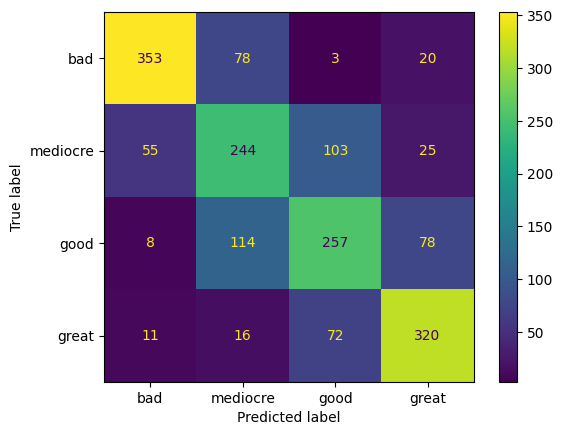

In [14]:
# Print confusion matrix for the model
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()

In [15]:
from sklearn.tree import DecisionTreeClassifier, export_text


surrogate_model = DecisionTreeClassifier(max_depth=10)  # Control complexity with max_depth
surrogate_model.fit(X_test, y_pred)

# Print the rules
tree_rules = export_text(surrogate_model, feature_names=df.columns[:-1].tolist())
print(tree_rules)

|--- num__vote_count <= -0.46
|   |--- num__vote_count <= -0.51
|   |   |--- num__runtime <= 0.59
|   |   |   |--- production_countries__brazil <= 0.50
|   |   |   |   |--- genres__music <= 0.50
|   |   |   |   |   |--- tagline__story <= 0.24
|   |   |   |   |   |   |--- production_companies__20thcenturyfox <= 0.50
|   |   |   |   |   |   |   |--- production_countries__portugal <= 0.50
|   |   |   |   |   |   |   |   |--- tagline__men <= 0.36
|   |   |   |   |   |   |   |   |   |--- overview__takes <= 0.74
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- overview__takes >  0.74
|   |   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |   |--- tagline__men >  0.36
|   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |--- production_countries__portugal >  0.50
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- production_companies__20thcenturyfox >  0.50
|   |   |   |  

# Feature importances on DL

In [16]:
def train_and_evaluate(X_train, Y_train, X_test, Y_test, num_epochs=10):
    input_size = X_train.shape[1]  # Number of input features
    model = MovieClassifier(input_size, num_classes)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5, amsgrad=True, eps=1e-8)

    # Create data loaders for training
    train_tensor = torch.FloatTensor(X_train.to_numpy())
    train_labels_tensor = torch.LongTensor(Y_train)
    train_dataset = torch.utils.data.TensorDataset(train_tensor, train_labels_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate on the test set
    model.eval()
    test_tensor = torch.FloatTensor(X_test.to_numpy())
    test_labels_tensor = torch.LongTensor(Y_test)
    test_dataset = torch.utils.data.TensorDataset(test_tensor, test_labels_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    y_pred = []
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            y_pred += predicted.cpu().numpy().tolist()

    return accuracy_score(Y_test, y_pred)

In [17]:

# Calculate baseline accuracy

baseline_accuracy = train_and_evaluate(X_train, Y_train, X_test, Y_test)
print(f'Baseline Accuracy: {baseline_accuracy:.4f}')

# Feature importance calculation
importances = {}

# Drop features that start with 'num' or 'cat' one at a time
for feature in X.columns:
    if feature.startswith('num') or feature.startswith('cat'):
        X_train_dropped = X_train.drop(feature, axis=1)
        X_test_dropped = X_test.drop(feature, axis=1)
        
        accuracy_dropped = train_and_evaluate(X_train_dropped, Y_train, X_test_dropped, Y_test)
        importances[feature] = baseline_accuracy - accuracy_dropped  # Importance is the drop in accuracy


groups = ['cast', 'director', 'production_companies', 'title', 'overview', 'tagline', 'production_countries', 'genres']

# Drop features one group at a time
for group in groups:
    features_to_drop = [feature for feature in X.columns if feature.startswith(group)]
    X_train_dropped = X_train.drop(features_to_drop, axis=1)
    X_test_dropped = X_test.drop(features_to_drop, axis=1)

    accuracy_dropped = train_and_evaluate(X_train_dropped, Y_train, X_test_dropped, Y_test)
    importances[group] = baseline_accuracy - accuracy_dropped  # Importance is the drop in accuracy

# Convert to a more interpretable format (e.g., DataFrame)
import pandas as pd
importance_df = pd.DataFrame(importances.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


Baseline Accuracy: 0.6796
                      Feature  Importance
4             num__vote_count    0.058623
5           num__release_year    0.043825
53                     genres    0.020489
35  cat__original_language_ro    0.019920
41  cat__original_language_th    0.017644
20  cat__original_language_fr    0.015936
26  cat__original_language_ja    0.014229
1                num__revenue    0.013090
7   cat__original_language_ar    0.012521
42  cat__original_language_tr    0.011383
29  cat__original_language_mk    0.010814
28  cat__original_language_la    0.010814
37  cat__original_language_sh    0.010245
30  cat__original_language_nb    0.009676
2             num__popularity    0.009676
11  cat__original_language_cs    0.009106
34  cat__original_language_pt    0.009106
39  cat__original_language_sv    0.008537
3                num__runtime    0.008537
12  cat__original_language_da    0.008537
17  cat__original_language_et    0.007968
21  cat__original_language_he    0.007968
9   cat_

In [18]:
# Drop columns with negative importance if they exist
columns_to_drop = importance_df[importance_df['Importance'] < 0]['Feature'].tolist()
X_columns = X.columns.tolist()
# keep columns that are not in columns_to_drop or that dont start with a column to drop
columns_to_keep = [col for col in X_columns if col not in columns_to_drop and not any(col.startswith(drop_col) for drop_col in columns_to_drop)]
X_train_filtered = X_train[columns_to_keep]
X_test_filtered = X_test[columns_to_keep]

In [19]:
train_and_evaluate(X_train_filtered, Y_train, X_test_filtered, Y_test, 50)

0.6607854297097325

In [20]:
from sklearn.metrics import classification_report

print("Classification Report for Neural Network:")
print(classification_report(Y_test, y_pred, target_names=label_encoder.classes_))


Classification Report for Neural Network:
              precision    recall  f1-score   support

         bad       0.83      0.78      0.80       454
    mediocre       0.54      0.57      0.56       427
        good       0.59      0.56      0.58       457
       great       0.72      0.76      0.74       419

    accuracy                           0.67      1757
   macro avg       0.67      0.67      0.67      1757
weighted avg       0.67      0.67      0.67      1757



In [21]:
def get_model_complexity(model):
    num_layers = 0
    total_nodes = 0
    total_connections = 0

    for name, layer in model.named_modules():
        if isinstance(layer, nn.Linear):
            num_layers += 1
            input_nodes, output_nodes = layer.weight.shape
            total_nodes += output_nodes
            total_connections += input_nodes * output_nodes + output_nodes  # +output_nodes for biases

            print(f"Layer {num_layers}: {input_nodes} -> {output_nodes} (Connections: {input_nodes * output_nodes + output_nodes})")

    print(f"\nTotal Number of Layers: {num_layers}")
    print(f"Total Number of Nodes: {total_nodes}")
    print(f"Total Number of Connections: {total_connections}")

get_model_complexity(model)


Layer 1: 128 -> 734 (Connections: 94686)
Layer 2: 64 -> 128 (Connections: 8320)
Layer 3: 16 -> 64 (Connections: 1088)
Layer 4: 4 -> 16 (Connections: 80)

Total Number of Layers: 4
Total Number of Nodes: 942
Total Number of Connections: 104174
